<a href="https://colab.research.google.com/github/calmrocks/master-machine-learning-engineer/blob/main/MLOps/MLPipeline.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Machine Learning Pipeline Implementation

## Overview

This notebook demonstrates a complete Machine Learning pipeline implementation following industry best practices. The pipeline includes data processing, model training, deployment, monitoring, and retraining phases.

![ML Pipeline](https://github.com/calmrocks/master-machine-learning-engineer/blob/main/MLOps/Diagrams/MLPipeline.png?raw=1)


## Data Processing

### Load Data
We'll start by loading our dataset and performing initial inspection. This step is crucial as it sets the foundation for our entire ML pipeline.


In [3]:
import pandas as pd
import numpy as np
from sklearn.datasets import fetch_california_housing

# Load dataset
housing = fetch_california_housing()
df = pd.DataFrame(housing.data, columns=housing.feature_names)
df['target'] = housing.target

# Display basic information about the dataset
print("Dataset shape:", df.shape)
print("\nFeatures:", housing.feature_names)
print("\nTarget description: Median house value in $100,000's")
print("\nFirst few rows:")
df.head()

Dataset shape: (20640, 9)

Features: ['MedInc', 'HouseAge', 'AveRooms', 'AveBedrms', 'Population', 'AveOccup', 'Latitude', 'Longitude']

Target description: Median house value in $100,000's

First few rows:


,MedInc,HouseAge,AveRooms,AveBedrms,Population,AveOccup,Latitude,Longitude,target
0,8.3252,41.0,6.984127,1.023810,322.0,2.555556,37.88,-122.23,4.526
1,8.3014,21.0,6.238137,0.971880,2401.0,2.109842,37.86,-122.22,3.585
2,7.2574,52.0,8.288136,1.073446,496.0,2.802260,37.85,-122.24,3.521
3,5.6431,52.0,5.817352,1.073059,558.0,2.547945,37.85,-122.25,3.413
4,3.8462,52.0,6.281853,1.081081,565.0,2.181467,37.85,-122.25,3.422


### Data Exploration (EDA)
Exploratory Data Analysis helps us understand our data's characteristics, distributions, and potential issues. We'll examine basic statistics, check for missing values, and visualize key distributions.


Basic Statistics:
             MedInc      HouseAge      AveRooms     AveBedrms    Population  \
count  20640.000000  20640.000000  20640.000000  20640.000000  20640.000000   
mean       3.870671     28.639486      5.429000      1.096675   1425.476744   
std        1.899822     12.585558      2.474173      0.473911   1132.462122   
min        0.499900      1.000000      0.846154      0.333333      3.000000   
25%        2.563400     18.000000      4.440716      1.006079    787.000000   
50%        3.534800     29.000000      5.229129      1.048780   1166.000000   
75%        4.743250     37.000000      6.052381      1.099526   1725.000000   
max       15.000100     52.000000    141.909091     34.066667  35682.000000   

           AveOccup      Latitude     Longitude        target  
count  20640.000000  20640.000000  20640.000000  20640.000000  
mean       3.070655     35.631861   -119.569704      2.068558  
std       10.386050      2.135952      2.003532      1.153956  
min        0.6

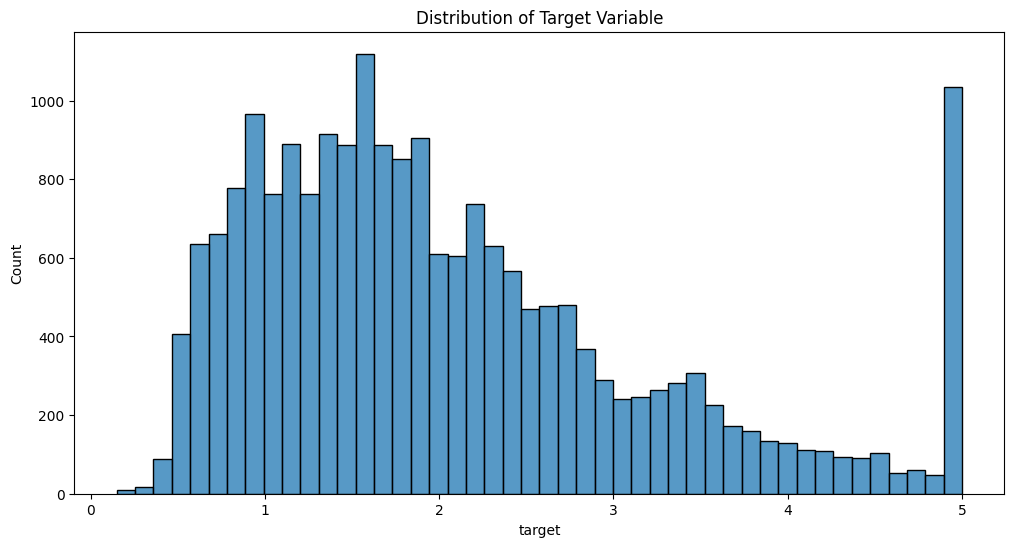

In [4]:
# Basic statistics
print("Basic Statistics:")
print(df.describe())

# Check for missing values
print("\nMissing Values:")
print(df.isnull().sum())

# Visualize distributions
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(12, 6))
sns.histplot(df['target'])
plt.title('Distribution of Target Variable')
plt.show()

### Data Cleaning & Preprocessing
In this step, we handle data quality issues such as missing values and outliers. We also prepare our data for modeling through scaling and encoding.


In [5]:
from sklearn.preprocessing import StandardScaler

# Handle outliers (example using IQR method)
def remove_outliers(df, column):
    Q1 = df[column].quantile(0.25)
    Q3 = df[column].quantile(0.75)
    IQR = Q3 - Q1
    df = df[~((df[column] < (Q1 - 1.5 * IQR)) | (df[column] > (Q3 + 1.5 * IQR)))]
    return df

# Scale features
scaler = StandardScaler()
df_scaled = pd.DataFrame(scaler.fit_transform(df.drop('target', axis=1)),
                        columns=df.drop('target', axis=1).columns)
df_scaled['target'] = df['target']


## Model Training

### Data Splitting
We split our data into training, validation, and test sets to ensure proper model evaluation and avoid data leakage.


In [6]:
from sklearn.model_selection import train_test_split

# Split features and target
X = df_scaled.drop('target', axis=1)
y = df_scaled['target']

# First split: separate test set
X_temp, X_test, y_temp, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Second split: separate train and validation sets
X_train, X_val, y_train, y_val = train_test_split(X_temp, y_temp, test_size=0.25, random_state=42)

print("Training set shape:", X_train.shape)
print("Validation set shape:", X_val.shape)
print("Test set shape:", X_test.shape)

Training set shape: (12384, 8)
Validation set shape: (4128, 8)
Test set shape: (4128, 8)


### Model Selection and Training
We'll train multiple models and compare their performance to select the best one. This includes evaluating different algorithms and their hyperparameters.


In [7]:
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score

# Initialize models
models = {
    'Linear Regression': LinearRegression(),
    'Random Forest': RandomForestRegressor(random_state=42)
}

# Train and evaluate models
results = {}
for name, model in models.items():
    # Train
    model.fit(X_train, y_train)

    # Predict on validation set
    val_pred = model.predict(X_val)

    # Calculate metrics
    mse = mean_squared_error(y_val, val_pred)
    r2 = r2_score(y_val, val_pred)

    results[name] = {'MSE': mse, 'R2': r2}

    print(f"\nResults for {name}:")
    print(f"MSE: {mse:.4f}")
    print(f"R2: {r2:.4f}")


Results for Linear Regression:
MSE: 0.5297
R2: 0.6142

Results for Random Forest:
MSE: 0.2598
R2: 0.8108


## Model Deployment

### Save Model
After selecting our best model, we save it for deployment. This step is crucial for moving the model to production.


In [8]:
import joblib

# Select best model (example: Random Forest)
best_model = models['Random Forest']

# Save model
joblib.dump(best_model, 'model.joblib')
print("Model saved successfully")


Model saved successfully


## Monitoring

### Performance Monitoring
Regular monitoring helps ensure our model maintains its performance in production. We'll set up basic monitoring metrics and alerts.



In [9]:
def monitor_performance(model, X, y_true, threshold=0.7):
    """
    Monitor model performance and raise alert if below threshold
    """
    y_pred = model.predict(X)
    r2 = r2_score(y_true, y_pred)

    print(f"Current R2 Score: {r2:.4f}")
    if r2 < threshold:
        print("ALERT: Model performance below threshold!")
    return r2

# Monitor current performance
current_performance = monitor_performance(best_model, X_test, y_test)

Current R2 Score: 0.8020


## Retraining

### Model Retraining
When performance degrades or new data becomes available, we need to retrain our model. Here's how we handle the retraining process.


In [10]:
def retrain_model(model, X_new, y_new, X_test, y_test):
    """
    Retrain model with new data and evaluate
    """
    # Retrain model
    model.fit(X_new, y_new)

    # Evaluate on test set
    test_pred = model.predict(X_test)
    new_r2 = r2_score(y_test, test_pred)

    print(f"New model R2 score: {new_r2:.4f}")
    return model

# Simulate new data (example)
X_new = X_train.copy()  # In real scenario, this would be new data
y_new = y_train.copy()

# Retrain model
updated_model = retrain_model(best_model, X_new, y_new, X_test, y_test)

New model R2 score: 0.8020


## Conclusion

This notebook has demonstrated a complete ML pipeline implementation including:
- Data processing and exploration
- Model training and selection
- Model deployment
- Performance monitoring
- Model retraining

**Production Considerations:**
- Implement robust data validation
- Set up proper model versioning
- Create automated retraining triggers
- Develop comprehensive monitoring systems
- Build APIs for model serving